In [3]:
import pandas as pd
import numpy as np
import os
import math
import PIL
from PIL import ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

# !pip install openslide-python
# need to download binaries and add bin to path
OPENSLIDE_PATH = os.path.join(r'C:\Users\Lior\Anaconda3\envs\pathology\openslide-bin\bin')

with os.add_dll_directory(OPENSLIDE_PATH):
    import openslide

In [4]:
SCALE_FACTOR = 32
TILES_SIZE = 32
TILE_PIXEL_THRESHOLD = 245
TILE_DROP_THRESHOLD = 0.95
TRAIN_NORMAL_PATH = './data/train/normal/'
TRAIN_TUMOR_PATH = './data/train/tumor/'
VAL_NORMAL_PATH = './data/val/normal/'
VAL_TUMOR_PATH = './data/val/tumor/'

In [5]:
def open_slide_as_array(filename: str, scale_factor: int = SCALE_FACTOR) -> np.array:
  """
  Open a svs file, scale it by scale_factor and convert to numpy array
  returns the np img, original and new dimensions
  """
  try:
    slide = openslide.open_slide(filename)
  except OpenSlideError as error:
    print(error)
    slide = None
  except FileNotFoundError as error:
    print(error)
    slide = None

  large_w, large_h = slide.dimensions
  new_w = math.floor(large_w / scale_factor)
  new_h = math.floor(large_h / scale_factor)
  level = slide.get_best_level_for_downsample(scale_factor)
  whole_slide_image = slide.read_region((0, 0), level, slide.level_dimensions[level])
  whole_slide_image = whole_slide_image.convert("RGB")
  img = whole_slide_image.resize((new_w, new_h), PIL.Image.BILINEAR)
  img = np.asarray(img)
  return img

In [6]:
def create_csv_w_filenames(name: str, normal_path, tumor_path) -> pd.DataFrame:
    ''' Downloaded images from:  https://portal.gdc.cancer.gov/analysis_page?app=Downloads 
        with filters normal/tumor and svs files.
        This function creates a dataframe with file name column and a target column, save it to a csv and returns the df'''
    normal_tissues_filenames = [os.path.join(normal_path, f) for f in os.listdir(normal_path)]
    tumor_tissues_filenames = [os.path.join(tumor_path, f) for f in os.listdir(tumor_path)]
    filenames = normal_tissues_filenames + tumor_tissues_filenames
    tags = [0] * len(normal_tissues_filenames) + [1]*len(tumor_tissues_filenames)
    print(filenames)
    print(tags)

    df = pd.DataFrame.from_dict({'file_name':filenames, 'tag':tags})
    df.to_csv(name)
    return df

In [7]:
df_train = create_csv_w_filenames('pathology_train_dataset.csv', TRAIN_NORMAL_PATH, TRAIN_TUMOR_PATH)
df_val = create_csv_w_filenames('pathology_train_dataset.csv', VAL_NORMAL_PATH, VAL_TUMOR_PATH)

['./data/train/normal/TCGA-34-2604-11A-01-BS1.f3489bd1-319f-4472-b09c-72f4c251ccbd.svs', './data/train/normal/TCGA-60-2698-11A-01-BS1.ca0fb378-b1f1-4bb7-b078-f56788cbec88.svs', './data/train/normal/TCGA-60-2710-11A-01-TS1.4f7b911e-5f72-4d83-a849-d56402dcc9a4.svs', './data/train/tumor/HCM-CSHL-0057-C18-01B-01-S1-HE.B9DFB327-AF35-41B4-85F1-0B594D076194.svs', './data/train/tumor/HCM-CSHL-0058-C34-01B-01-S1-HE.1FDC6ED6-4820-48FF-977B-5C82FC13B101.svs', './data/train/tumor/HCM-CSHL-0059-C25-01A-01-S1-HE.F2261D51-D4E4-4E8A-A707-331ED4E46ECC.svs', './data/train/tumor/HCM-CSHL-0080-C25-01A-01-S1-HE.7BBD7E7A-069E-4FAC-A5C0-519E23571AB5.svs', './data/train/tumor/HCM-CSHL-0160-C18-01B-01-S1-HE.902091A8-28E8-4152-9688-DBCEB518CBF0.svs', './data/train/tumor/HCM-CSHL-0322-C20-01B-01-S2-HE.63178495-7D66-4D21-B9FA-BC3455283A17.svs', './data/train/tumor/HCM-CSHL-0459-C17-01B-01-S2-HE.A68FCFF8-2A0B-4583-BE5D-28D9CAFB27B0.svs']
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
['./data/val/normal/TCGA-34-8455-11A-01-TS1.6a

In [8]:
def examine_tissues(df:pd.DataFrame = None, path_to_folder: str = None) -> None:    
    def show_img(tissue_path):
        if tissue_path.endswith('svs'):
            img = open_slide_as_array(tissue_path)
            plt.imshow(img)
            plt.title(tissue_path)
            plt.show()

    if df is None:
        for tissue_path in os.listdir(path_to_folder):
            show_img(os.path.join(path_to_folder,tissue_path))
    else:
        df['file_name'].apply(show_img)

In [119]:
# examine_tissues(path_to_folder=r'C:\Users\Lior\Documents\Python Scripts\samueli\data\val\tumor')

In [9]:
def keep_tile(tile: np.array) -> np.array:
    return sum(sum(sum(tile > TILE_PIXEL_THRESHOLD))) / (TILES_SIZE*TILES_SIZE*3) < TILE_DROP_THRESHOLD

def divide_img_to_tiles(img: np.array, tiles_size: int = TILES_SIZE) -> np.array:
    '''
    create and return a np array of square tiles with a set size (TILES_SIZE) from a np array representing a whole slide image
    if the image size doesn't divide by TILES_SIZE, the edges (right & bottom) get negleted, with the asumption that there won't be tissue in the edges.
    '''
    height, width, _ = img.shape

    # Calculate the number of squares along each dimension
    num_tiles_height = height // tiles_size
    num_tiles_width = width // tiles_size

    # List to store the squares
    tiles = []

    # Extract 20x20 squares
    for i in range(num_tiles_height):
        for j in range(num_tiles_width):
            tile = img[i * tiles_size:(i + 1) * tiles_size, j * tiles_size:(j + 1) * tiles_size]
            if keep_tile(tile):
                tiles.append(tile)

    return np.stack(tiles)

In [10]:
def create_tiles_dataset(df: pd.DataFrame) -> tuple[np.array, np.array, list]:
    '''
    Given a dataframe of wsl filenames and their tag, this function creates X and y arrays by reading the images, dividing to tiles and reorganizing them.
    In addition to X,y, the function also returns the tiles' amounts per image for later evaluation
    '''
    tiles_dataset = []
    targets = []

    df = df.sample(frac=1).reset_index(drop=True)

    for i in df.index:
        img = open_slide_as_array(df.iloc[i]['file_name'])
        tiles = divide_img_to_tiles(img, tiles_size=TILES_SIZE)
        tiles_dataset.append(tiles)
        targets.append([df.iloc[i]['tag']] * len(tiles))

    return np.concatenate(tiles_dataset), np.concatenate(targets), [img.shape[0] for img in tiles_dataset]

In [11]:
# create datasets
X_train, y_train, tiles_amounts_train = create_tiles_dataset(df_train)
X_val, y_val, tiles_amounts_val = create_tiles_dataset(df_val)

In [12]:
print(f'Train sizes: X: {X_train.shape}, y: {y_train.shape} \nValidation sizes: X: {X_val.shape}, y: {y_val.shape}')

Train sizes: X: (10793, 32, 32, 3), y: (10793,) 
Validation sizes: X: (5819, 32, 32, 3), y: (5819,)


Fine tuning ResNet50:

In [19]:
# Load the pretrained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(TILES_SIZE, TILES_SIZE, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
predictions = Dense(1, activation='sigmoid')(x)  # Output layer 

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss='binary_crossentropy')

# model.summary()

model_fit = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 84s 221ms/step - loss: 0.6801 - val_loss: 0.5737
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 72s 212ms/step - loss: 0.3847 - val_loss: 0.5271
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 71s 211ms/step - loss: 0.3655 - val_loss: 0.5756
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 69s 204ms/step - loss: 0.3567 - val_loss: 0.6379
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 70s 207ms/step - loss: 0.3481 - val_loss: 0.6520
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 68s 202ms/step - loss: 0.3357 - val_loss: 0.6990
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 68s 202ms/step - loss: 0.3332 - val_loss: 0.6456
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 61s 182ms/step - loss: 0.3151 - val_loss: 0.7733
Epoch 9/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 194ms/step - loss: 0.3152 - val_loss: 0.7220
Epoch 10/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 64s 188ms/step - loss: 0.3080 - val_loss: 0.7107


In [20]:
model.save("model.keras")
# model = keras.saving.load_model("model.keras")

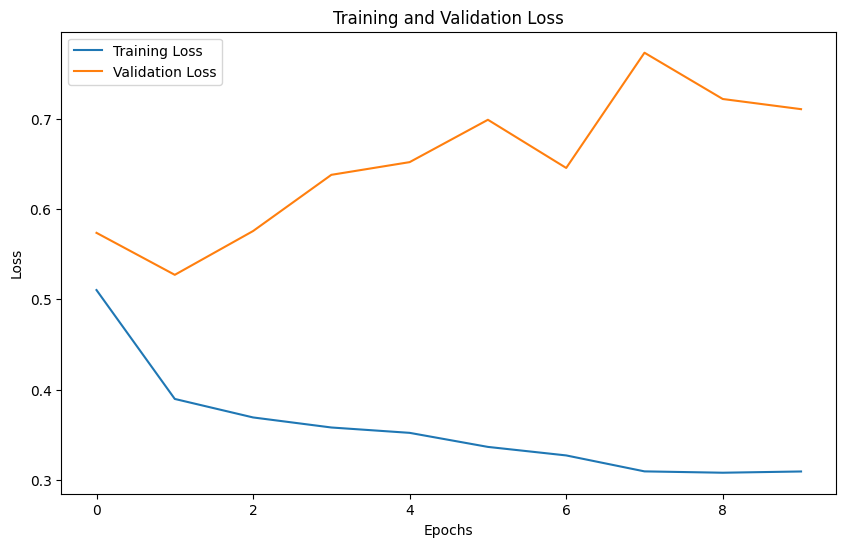

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(model_fit.history['loss'], label='Training Loss')
plt.plot(model_fit.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

That's an obvious case of overfitting.

The evaluation process seems a bit silly here, since we only have 10 images in training and I added 4 images for validation.
We'll discuss it here mostly theoratically.

This task is a binary classification task.
Popular metrics to evaluate outcomes are: accuracy, precision, recall, F1, AUC.

The accuracy shows the overall score, how many of the tissues we classified correctly, tumor or normal. Accuracy is only relevant if our val/test data is balanced.
The recall shows how many of the tumor examples we succesfully identified.
The precision shows how many of what we identified as tumor actually is tumor.

while it's always good to view over a few metrics, choosing the most appropriate metric 
depends on the objective and what you want to achieve.
If falsely alerting that a tumor was found is severe, we should especially make sure our precision is high.
If missing out tumors is unacceptable, we should especially make sure our recall is high.
I would guess the latter is the most appropriate one and we should focus on recall.

If both is equally important, we should check out F1.
And in that case, it's also important to check the auc roc score, that maps the relationship 
between tpr and fpr of the model across different thresholds. It mostly shines when the classes 
are imbalanced.

In [22]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)


train_preds_round = np.round(train_preds).astype(int)
val_preds_round = np.round(val_preds).astype(int)

338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 123ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step


In [37]:
def get_img_preds(preds: np.array, tiles_amounts_list: list) -> np.array:
    preds_imgs = []
    pos = 0 
    for tiles_amounts in tiles_amounts_list:
        preds_imgs.append(preds[pos:pos+tiles_amounts].mean())
        pos += tiles_amounts
    return np.round(np.array(preds_imgs)).astype(int)

In [38]:
train_preds_imgs = get_img_preds(train_preds, tiles_amounts_train)
val_preds_imgs = get_img_preds(val_preds, tiles_amounts_val)

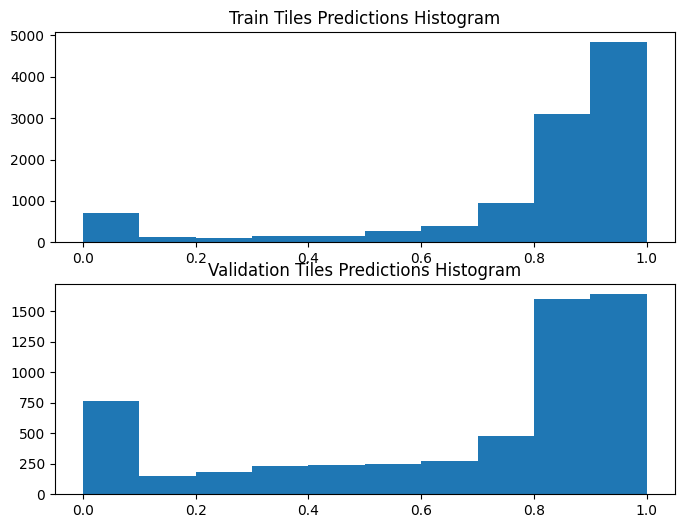

In [55]:
fig, axes = plt.subplots(2,1,figsize=(8,6))
axes[0].hist(np.squeeze(train_preds));
axes[1].hist(np.squeeze(val_preds));
axes[0].set_title('Train Tiles Predictions Histogram')
axes[1].set_title('Validation Tiles Predictions Histogram')
plt.show()

In [57]:
from sklearn import metrics
print('Outcomes per tile: \n')
print('train accuracy: ', np.round(metrics.accuracy_score(y_train, train_preds_round),4))
print('train recall: ', np.round(metrics.recall_score(y_train, train_preds_round),4))
print('train precision: ', np.round(metrics.precision_score(y_train, train_preds_round),4))
print('train f1: ', np.round(metrics.f1_score(y_train, train_preds_round),4))

print('\nval accuracy: ', np.round(metrics.accuracy_score(y_val, val_preds_round),4))
print('val recall: ', np.round(metrics.recall_score(y_val, val_preds_round),4))
print('val precision: ', np.round(metrics.precision_score(y_val, val_preds_round),4))
print('val f1: ', np.round(metrics.f1_score(y_val, val_preds_round),4))

print('\nOutcomes per image: \n')
print('train accuracy: ', np.round(metrics.accuracy_score(get_img_preds(y_train, tiles_amounts_train), train_preds_imgs),4))
print('train recall: ', np.round(metrics.recall_score(get_img_preds(y_train, tiles_amounts_train), train_preds_imgs),4))
print('train precision: ', np.round(metrics.precision_score(get_img_preds(y_train, tiles_amounts_train), train_preds_imgs),4))
print('train f1: ', np.round(metrics.f1_score(get_img_preds(y_train, tiles_amounts_train), train_preds_imgs),4))

print('\nval accuracy: ', np.round(metrics.accuracy_score(get_img_preds(y_val, tiles_amounts_val), val_preds_imgs),4))
print('val recall: ', np.round(metrics.recall_score(get_img_preds(y_val, tiles_amounts_val), val_preds_imgs),4))
print('val precision: ', np.round(metrics.precision_score(get_img_preds(y_val, tiles_amounts_val), val_preds_imgs),4))
print('val f1: ', np.round(metrics.f1_score(get_img_preds(y_val, tiles_amounts_val), val_preds_imgs),4))

Outcomes per tile: 

train accuracy:  0.8784
train recall:  0.9831
train precision:  0.8777
train f1:  0.9274

val accuracy:  0.7687
val recall:  0.8999
val precision:  0.7685
val f1:  0.829

Outcomes per image: 

train accuracy:  0.9
train recall:  1.0
train precision:  0.875
train f1:  0.9333

val accuracy:  0.75
val recall:  1.0
val precision:  0.6667
val f1:  0.8


Hard to judge the model with so little data, but outcomes are surprisingly not the worse.
Still, you see the outcomes of the train data is better.

The model can't seem to understand what inidicates that a tile containes a tumor which makes perfect sense, since most of the tiles in a tumorous slide image don't contain a tumor, but they are all tagged as they contain a tumor, since we don't have better tags (segmentation).

How to improve results:

1. Change the target / loss function. As stated, the target is not accurate at all. A few possible fixes:
    a. change loss function to use BCE on the mean of all tiles of the same slide image to that image's target
    b. change data to contain only image data and divide into tiles inside the net
    c. change the target to contain only images tags and average the last layer by tiles and compare
2. ADD DATA. and gpus :)
3. Add data augmentations to increase dataset - rotations, movements
4. Process data: grey-scale, HSV dimensions, protain-nuclei dimensions
5. Hyper parameter tuning - change loss, optimizer, lr, epochs...
6. Multi-modality model - add more data on the person in addition to the tissue slide image (age, smoking...)
7. Split data into tissue types and train seperately. I saw some very different-looking tissues, the model might have difficulty generalizing to all kinds and have more success training and predicting for each tissue type alone. 
